In [3]:
from scipy import stats
from numpy import log,sqrt,exp
def call_option_price(S,E,T,rf,sigma):
    #first we need to calculate d1 d2 parameters
    #calculating price at t=0
    d1=(log(S/E)+(rf+sigma*sigma/2.0)*T)/(sigma*sqrt(T))
    d2=d1-sigma*sqrt(T)
    print("d1 and d2 parameters: %s and %s"%(d1 ,d2))
    #use the N(x) to calculate the price of the option
    # cdf is the standardized normal distribution argument
    #E*exp(-rf*T) calculates the present valur of stikr price(discounting exp factor)
    return S*stats.norm.cdf(d1)-E*exp(-rf*T)*stats.norm.cdf(d2)
def put_option_price(S,E,T,rf,sigma):
    #first we need to calculate d1 d2 parameters
    #calculating price at t=0
    d1=(log(S/E)+(rf+sigma*sigma/2.0)*T)/(sigma*sqrt(T))
    d2=d1-sigma*sqrt(T)
    print("d1 and d2 parameters: %s and %s"%(d1 ,d2))
    #use the N(x) to calculate the price of the option
    # cdf is the standardized normal distribution argument
    #E*exp(-rf*T) calculates the present valur of stikr price(discounting exp factor)
    return -S*stats.norm.cdf(-d1)+E*exp(-rf*T)*stats.norm.cdf(-d2)
    

In [4]:
if __name__=="__main__":
    #underlying stock price at t=0 
    S0=100
    # strike price
    E=100
    # expiry 1=1year=365days
    T=1
    #risk free rate
    rf=0.05
    #volatility of the underlying stock
    sigma=0.2
    print("Call option price according to Black-Scholes model: ",
          call_option_price(S0, E, T, rf, sigma))
    print("Put option price according to Black-Scholes model: ",
          put_option_price(S0, E, T, rf, sigma))

d1 and d2 parameters: 0.35000000000000003 and 0.15000000000000002
Call option price according to Black-Scholes model:  10.450583572185565
d1 and d2 parameters: 0.35000000000000003 and 0.15000000000000002
Put option price according to Black-Scholes model:  5.573526022256971


In [45]:
# monte carlo stimulation to guess the price in the future
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
NUM_OF_SIMULATIONS=1000
def stock_monte_carlo(S0,mu,sigma,N=252):#N=number of points generated through geometric random walk
    #predicting the price at the end of the year (trading days is equal to 252)
    result=[]
    #number of simulations- number of s(t) relizations (of stochastic process)
    for _ in range(NUM_OF_SIMULATIONS):
        prices=[S0]
        for _ in range(N):
            # we simulate the change day by day (t=1)
            stock_price = prices[-1] * np.exp((mu - 0.5 * sigma ** 2) +
                                              sigma * np.random.normal())#np.random.normal() mu=0 sigma=1
            prices.append(stock_price)
        result.append(prices)
    # every row is going to be one relization of s(T)
    simulation_data=pd.DataFrame(result)
    # the given columns will contain the time series for a given simulation
    simulation_data = simulation_data.T
    #mean on day by day basis
    simulation_data['mean'] = simulation_data.mean(axis=1)#row by row basis
    plt.plot(simulation_data['mean'])
    plt.show()
    print('Prediction for future stock price: $%.2f' % simulation_data['mean'].tail(1))
    #plt.plot(simulation_data)
    #plt.show()
    #print(simulation_data)#number of columns=NUM_OF_SIMULATIONS and number of rows=N=1000
    plt.figure(figsize=(10, 6))
    plt.plot(simulation_data.iloc[: , :-1])
    plt.plot(simulation_data['mean'],color="black")
    plt.show()

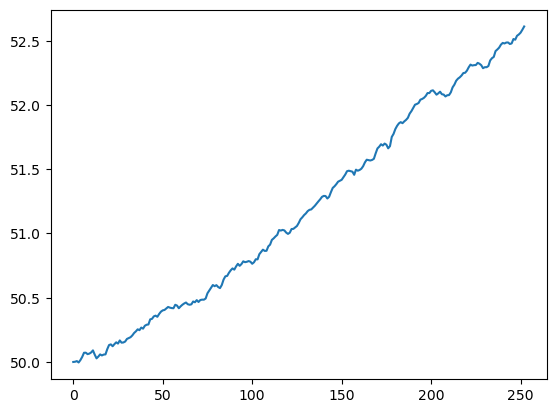

Prediction for future stock price: $52.61


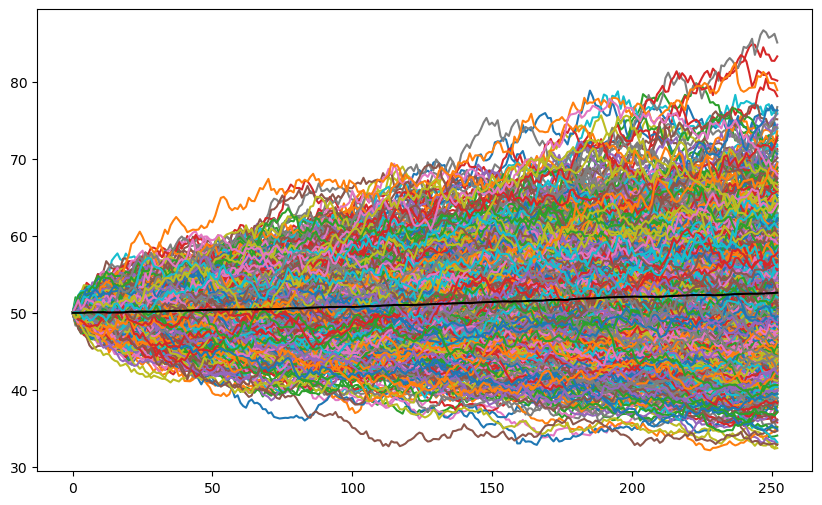

In [46]:
if __name__=="__main__":
    stock_monte_carlo(50,0.0002,0.01)

In [51]:
# using monte carlo stimulation to estimate the stock price at expiry then using max((s-E),0) to the vlaue of call option at expiry
import numpy as np
import math
import time
 
class OptionPricing:
    def __init__(self,S0,E,T,rf,sigma,iterations):
        self.S0 = S0
        self.E = E
        self.T = T
        self.rf = rf
        self.sigma = sigma     
        self.iterations = iterations 
 
    def call_option_simulation(self):

        #we have 2 columns: first with 0s the second column will store the payoff
        #we need the first column of 0s: payoff function is max(0,S-E) for call option
        option_data = np.zeros([self.iterations, 2])

        #dimensions: 1 dimensional array with as many items as the itrations
        rand = np.random.normal(0, 1, [1, self.iterations])
        
        #equation for the S(t) stock price
        stock_price = self.S0*np.exp(self.T*(self.rf - 0.5*self.sigma**2)+self.sigma*np.sqrt(self.T)*rand)
 
        #we need S-E because we have to calculate the max(S-E,0)
        option_data[:,1] = stock_price - self.E   
        
        #average for the Monte-Carlo method
        #np.amax() returns the max(0,S-E) according to the formula
        average = np.sum(np.amax(option_data, axis=1))/float(self.iterations)
 
        #have to use the exp(-rT) discount factor
        return np.exp(-1.0*self.rf*self.T)*average
        
    def put_option_simulation(self):
    
        #we have 2 columns: first with 0s the second column will store the payoff
        #we need the first column of 0s: payoff function is max(0,E-S) for put option
        option_data = np.zeros([self.iterations, 2])
        
        #dimensions: 1 dimensional array with as many items as the itrations
        rand = np.random.normal(0, 1, [1, self.iterations])
        
        #equation for the S(t) stock price
        stock_price = self.S0*np.exp(self.T*(self.rf - 0.5*self.sigma**2)+self.sigma*np.sqrt(self.T)*rand)
 
        #we need E-S because we have to calculate the max(E-S,0)
        option_data[:,1] = self.E - stock_price  
        
        #average for the Monte-Carlo method
        #np.amax() returns the max(0,E-S) according to the formula
        average = np.sum(np.amax(option_data, axis=1))/float(self.iterations)
 
        #have to use the exp(-rT) discount factor
        return np.exp(-1.0*self.rf*self.T)*average

if __name__ == "__main__":
    S0=100#underlying stock price at t=0
    E=100 #strike price
    T = 1 #expiry
    rf = 0.05 #risk-free rate
    sigma=0.2 #volatility of the underlying stock
    iterations = 1000000 #number of iterations in the Monte-Carlo simulation	
    
    model = OptionPricing(S0,E,T,rf,sigma,iterations)
    print("Call option price with Monte-Carlo approach: ", model.call_option_simulation()) 
    print("Put option price with Monte-Carlo approach: ", model.put_option_simulation())

Call option price with Monte-Carlo approach:  10.486317397849685
Put option price with Monte-Carlo approach:  5.570652337413738
